<a href="https://colab.research.google.com/github/Khotso-Bore/Local-Recoding-Anonymization/blob/Innocentia's/local_recoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [112]:
from pprint import pprint

import pandas as pd
import numpy as np

### Prepare Dataset

In [113]:
df = pd.read_csv('adult/adult.data', header=None,names=[
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "income"
]
 )

In [114]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [115]:
df.dropna(inplace=True)

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


### drop coloumns

In [117]:
drop_columns = ['capital-gain', 'capital-loss', 'fnlwgt', 'education-num','income']

'''
# Drop unnecessary columns
These columns are dropped as they are not needed as
they may not contain any sensitive information.
required for the local recoding anonymization process.
'''
df.drop(columns=drop_columns, inplace=True)

In [118]:
# count number of columns
print(f"Number of columns after dropping unnecessary columns: {len(df.columns)}")

Number of columns after dropping unnecessary columns: 10


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   education       32561 non-null  object
 3   marital-status  32561 non-null  object
 4   occupation      32561 non-null  object
 5   relationship    32561 non-null  object
 6   race            32561 non-null  object
 7   sex             32561 non-null  object
 8   hours-per-week  32561 non-null  int64 
 9   native-country  32561 non-null  object
dtypes: int64(2), object(8)
memory usage: 2.5+ MB


In [120]:
print("Sensitive Attribute - workclass value counts:")
df['workclass'].value_counts()

Sensitive Attribute - workclass value counts:


workclass
Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: count, dtype: int64

In [121]:
# Show the first row where 'workclass' contains '?'
missing_value = df[df['workclass'].str.contains('?', regex=False)]['workclass'].head(1).values[0]
print(f"Missing value representation in 'workclass': {missing_value}")

Missing value representation in 'workclass':  ?


In [122]:
df.replace(missing_value,np.nan,inplace=True)
df.dropna(inplace=True)
df['workclass'].value_counts()



workclass
Private             22286
Self-emp-not-inc     2499
Local-gov            2067
State-gov            1279
Self-emp-inc         1074
Federal-gov           943
Without-pay            14
Name: count, dtype: int64

In [123]:
df['marital-status'].value_counts()

marital-status
Married-civ-spouse       14065
Never-married             9726
Divorced                  4214
Separated                  939
Widowed                    827
Married-spouse-absent      370
Married-AF-spouse           21
Name: count, dtype: int64

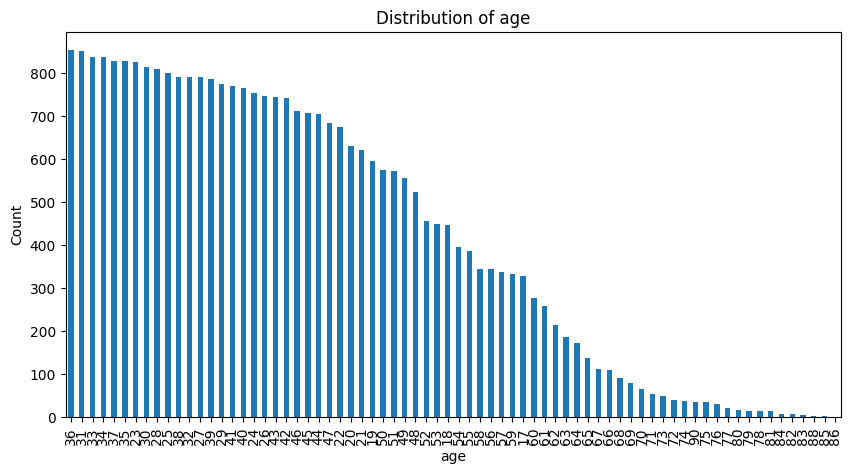

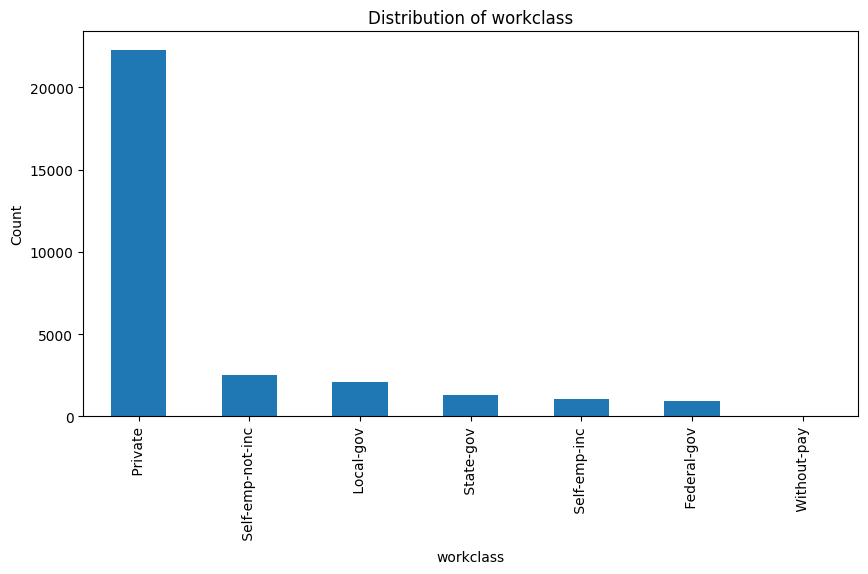

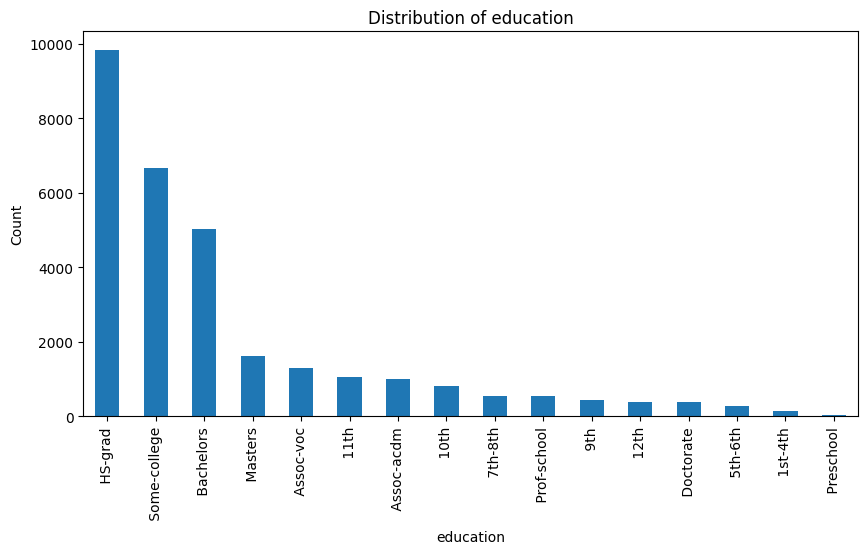

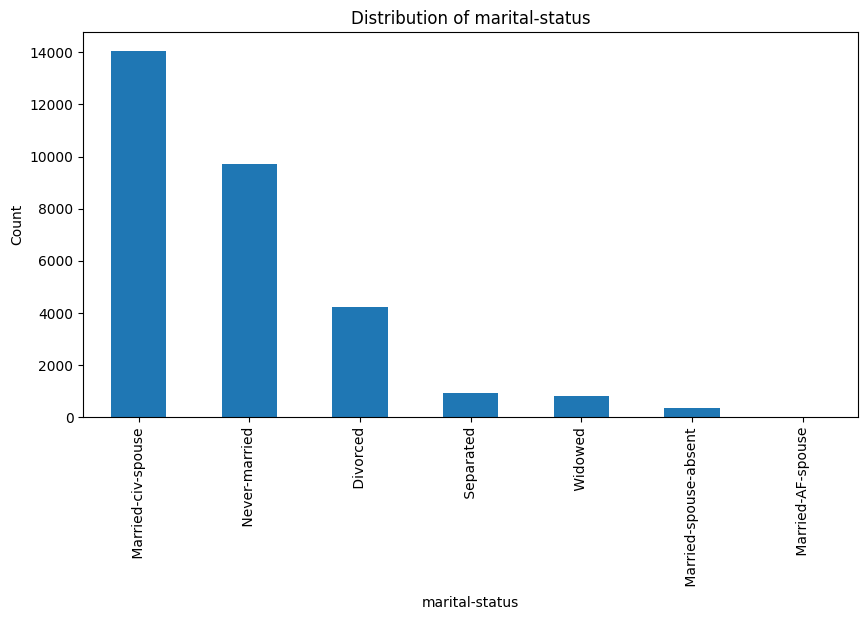

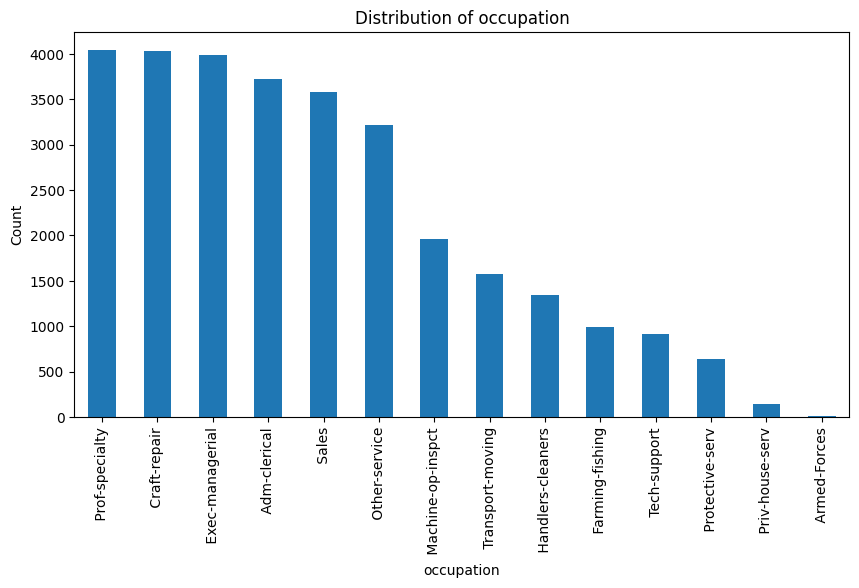

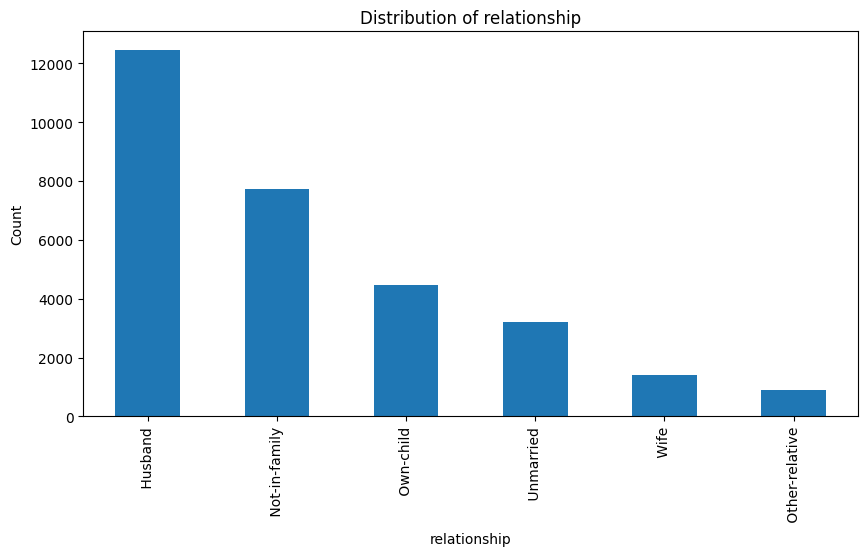

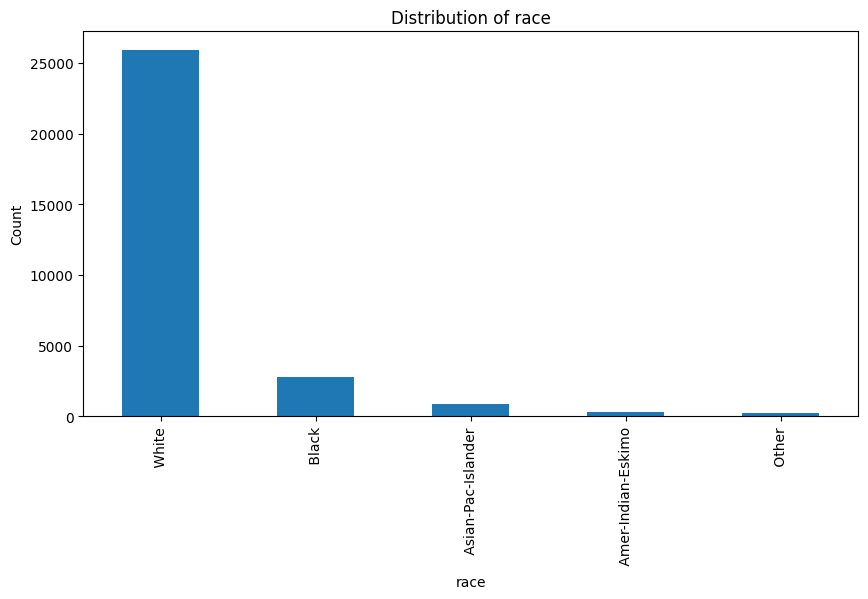

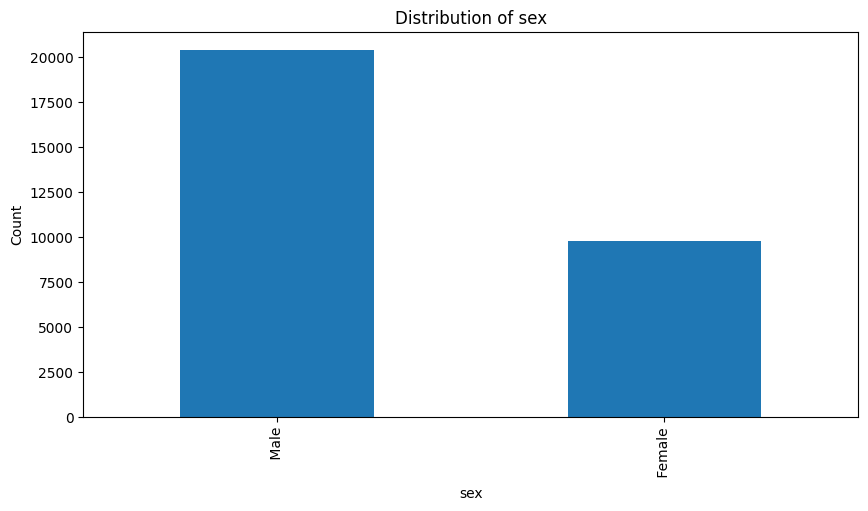

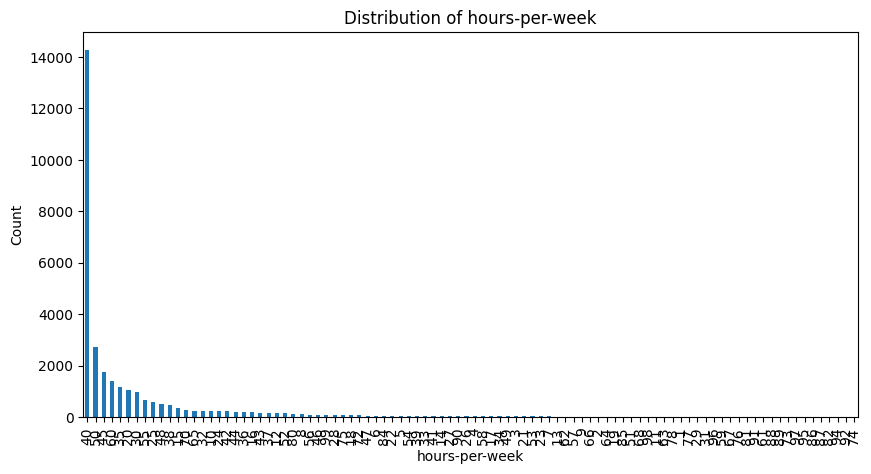

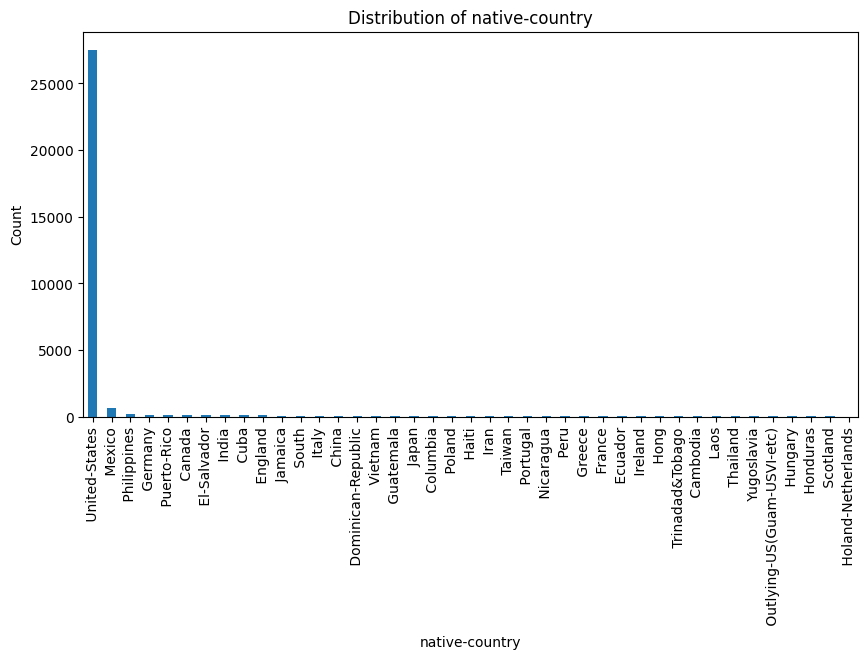

In [124]:
#plot the distribution of every column
import matplotlib.pyplot as plt
for column in df.columns:
    plt.figure(figsize=(10,5))
    df[column].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()

# Algorithm 2

In [125]:
#save unqiq values of each column to as a string array
unique_values = {}
for column in df.columns:
    unique_values[column] = df[column].unique().tolist()
    print(f"Unique values in {column}: {unique_values[column]}")


Unique values in age: [39, 50, 38, 53, 28, 37, 49, 52, 31, 42, 30, 23, 32, 34, 25, 43, 40, 54, 35, 59, 56, 19, 20, 45, 22, 48, 21, 24, 57, 44, 41, 29, 47, 46, 36, 79, 27, 18, 33, 76, 55, 61, 70, 64, 71, 66, 51, 58, 26, 17, 60, 90, 75, 65, 77, 62, 63, 67, 74, 72, 69, 68, 73, 81, 78, 88, 80, 84, 83, 85, 82, 86]
Unique values in workclass: [' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov', ' Local-gov', ' Self-emp-inc', ' Without-pay']
Unique values in education: [' Bachelors', ' HS-grad', ' 11th', ' Masters', ' 9th', ' Some-college', ' Assoc-acdm', ' 7th-8th', ' Doctorate', ' Assoc-voc', ' Prof-school', ' 5th-6th', ' 10th', ' Preschool', ' 12th', ' 1st-4th']
Unique values in marital-status: [' Never-married', ' Married-civ-spouse', ' Divorced', ' Married-spouse-absent', ' Separated', ' Married-AF-spouse', ' Widowed']
Unique values in occupation: [' Adm-clerical', ' Exec-managerial', ' Handlers-cleaners', ' Prof-specialty', ' Other-service', ' Sales', ' Transport-moving', ' F

In [126]:
import json

with open('taxonomy-tree.json', 'r') as f:
    taxonomy_dict = json.load(f)

# Display the dictionary
taxonomy_dict

{'workclass': {'Government': ['Federal-gov', 'State-gov', 'Local-gov'],
  'Self-Employed': ['Self-emp-inc', 'Self-emp-not-inc'],
  'Private Sector': ['Private'],
  'Other': ['Without-pay']},
 'education': {'Preschool': {'Preschool': {'Preschool': ['Preschool']}},
  'Primary': {'Lower Primary': {'1st-4th': ['1st-4th']},
   'Upper Primary': {'5th-6th': ['5th-6th']},
   'Lower High': {'7th-8th': ['7th-8th']}},
  'Secondary': {'Junior': {'9th': ['9th'], '10th': ['10th']},
   'Senior': {'11th': ['11th'], '12th': ['12th'], 'HS-grad': ['HS-grad']}},
  'Post-Secondary': {'College': {'Some-college': ['Some-college'],
    'Assoc-acdm': ['Assoc-acdm'],
    'Assoc-voc': ['Assoc-voc']},
   'University': {'Bachelor': ['Bachelors'],
    'Graduate': ['Masters', 'Doctorate', 'Prof-school']}}},
 'marital-status': {'Married': ['Married-civ-spouse',
   'Married-spouse-absent',
   'Married-AF-spouse'],
  'Single': ['Never-married'],
  'Divorced/Separated/Widowed': ['Divorced', 'Separated', 'Widowed']},
 'o

In [127]:
#invert the taxonomy dictionary to get child to parent mapping
def invert_taxonomy_tree(taxonomy, path=[]):
    inverted_taxonomy_tree = {}
    for key in taxonomy:


        extended_path = [key] + path
        # if(key == "workclass"):
        #     print(taxonomy[key])
        #     print(path)
        # print(f"Current key: {key}, Current path: {path}")
        if isinstance(taxonomy[key], dict):
            result = invert_taxonomy_tree(taxonomy[key], extended_path)
            inverted_taxonomy_tree.update(result)
            # if(key == "workclass"):
            #     print(inverted_taxonomy_tree)

        if isinstance(taxonomy[key], list):
            for item in taxonomy[key]:
                inverted_taxonomy_tree[item] = [item] + extended_path

        # path = []
    return inverted_taxonomy_tree

inverted_taxonomy_tree = invert_taxonomy_tree(taxonomy_dict, [])
for key in inverted_taxonomy_tree:
    print(f"{key}: {inverted_taxonomy_tree[key]}")


Federal-gov: ['Federal-gov', 'Government', 'workclass']
State-gov: ['State-gov', 'Government', 'workclass']
Local-gov: ['Local-gov', 'Government', 'workclass']
Self-emp-inc: ['Self-emp-inc', 'Self-Employed', 'workclass']
Self-emp-not-inc: ['Self-emp-not-inc', 'Self-Employed', 'workclass']
Private: ['Private', 'Private Sector', 'workclass']
Without-pay: ['Without-pay', 'Other', 'workclass']
Preschool: ['Preschool', 'Preschool', 'Preschool', 'Preschool', 'education']
1st-4th: ['1st-4th', '1st-4th', 'Lower Primary', 'Primary', 'education']
5th-6th: ['5th-6th', '5th-6th', 'Upper Primary', 'Primary', 'education']
7th-8th: ['7th-8th', '7th-8th', 'Lower High', 'Primary', 'education']
9th: ['9th', '9th', 'Junior', 'Secondary', 'education']
10th: ['10th', '10th', 'Junior', 'Secondary', 'education']
11th: ['11th', '11th', 'Senior', 'Secondary', 'education']
12th: ['12th', '12th', 'Senior', 'Secondary', 'education']
HS-grad: ['HS-grad', 'HS-grad', 'Senior', 'Secondary', 'education']
Some-college:

## Provenence Set

In [128]:
def provenance(values):
    result = []
    for value in values:
        mapping = inverted_taxonomy_tree.get(value, None)
        if mapping:
            result = result + mapping[:-1]  # Exclude the original value
    return result


In [129]:
df.head(1).values[0]

array([39, ' State-gov', ' Bachelors', ' Never-married', ' Adm-clerical',
       ' Not-in-family', ' White', ' Male', 40, ' United-States'],
      dtype=object)

In [130]:

first_row = list(df.head(1).values[0])
first_row = [s.strip() for s in first_row if isinstance(s, str)]


In [131]:
provenance(first_row)

['State-gov',
 'Government',
 'Bachelors',
 'Bachelor',
 'University',
 'Post-Secondary',
 'Never-married',
 'Single',
 'Adm-clerical',
 'Management & Administration',
 'Not-in-family',
 'Non-Family',
 'White',
 'Male',
 'United-States',
 'North America']

In [132]:
education_tree = {
        "Secondary": {
            "Junior": ["9th", "10th"],
            "Senior": ["11th", "12th"]
        },
        "University": {
            "Bachelor": ["Bachelor"],
            "Graduate": ["Master", "Doctorate"]
        }
}

# education_tree = {
#     "Any_Education": ["hello"]
# }


## Algorith 2 characteristic_vector_converting

In [133]:
def characteristic_vector_converting(taxonomy_tree, values, inverted_taxonomy_tree):
    characteristic_vector = []
    # print(f"Values to process for characteristic vector: {values}")
    for val in values:
        # print(f"Processing value: {val}")
        val = val.strip()
        last_value = inverted_taxonomy_tree[val][-1]
        # print(f"Processing value: {val}, Last value in taxonomy path: {last_value}")
        # Get the values in the inverted taxonomy tree that have key as the last value
        arr = []
        for k in inverted_taxonomy_tree:
            mapping = inverted_taxonomy_tree[k]
            if mapping and mapping[-1] == last_value:
                arr.append(mapping[:-1])  # Exclude the original value

        arr = np.array(arr)
        # print(arr.shape)
        # print(arr)
        # for each column in arr
        # print(arr.shape[1])
        provenance_set = provenance([val])
        for col in range(len(provenance_set)):  # every column except last column
            # Get the unique values in the column
            coloumn_values = arr[:, col]
            unique_values = np.unique(coloumn_values)
            # print(f"Unique values in column {provenance_set[col]}: {unique_values}")
            # print(f"Value to encode: {unique_values[0]}")
            vector = [0] * len(unique_values)
            # print(val)
            index = np.where(unique_values == provenance_set[col])[0][0]
            # print(f"Index of value {val} in unique values: {index}")
            vector[index] = 1
            characteristic_vector.extend(vector)
            # Do something with the vector
    return characteristic_vector


In [134]:
first_row[-2:]

['Male', 'United-States']

In [135]:
characteristic_vector_converting(taxonomy_dict, first_row, inverted_taxonomy_tree)

[0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1]

# Experiment parameters

In [136]:
import random

In [137]:
# k=??
# theta=??
alpha=50

# Creating set of hash functions (universal use)

In [138]:

# creates set F of hash functions Hash functions in F are in
#  the form of h(x)=(ax+b) mod NPrime, where a and b are
#  random integers, and NPrime is the smallest prime number
#  larger than |U|.

# F is a list of hash functions
# Each hash function h takes an input x (row index in the characteristic vector)
# and outputs a hashed value modulo a large prime number.
# Example: h(x) = (a * x + b) % N_prime
U=len(characteristic_vector_converting(taxonomy_dict, first_row, inverted_taxonomy_tree))
random.seed(42)
def create_hash_fam(num_hashes,U_size):
  def is_prime(n):
    if n<2:
      return False

    for i in range(2,int(n**0.5)+1):
      if n%i==0:
        return False
    return True

  def next_prime(n):
    while not is_prime(n):
      n=n+1
    return n

  N_prime=next_prime(U_size +1)

  F=[]

  for i in range(num_hashes):
    a=random.randint(1,N_prime-1)
    b=random.randint(0,N_prime-1)
    h = lambda x, a=a, b=b, N_prime=N_prime: (a * x + b) % N_prime
    F.append(h)
  return F
F = create_hash_fam(num_hashes=alpha, U_size=U)

# Algorithm 4

In [139]:
import random

In [140]:
from math import inf
###ALGORITHM 4
def minhash(characteristic_vec,h_ab):
  min_hash=float('inf')
  for i,bit in enumerate(characteristic_vec):
      if bit==1:
        index=h_ab(i+1)
        if index<min_hash:
          min_hash=index

  return min_hash


In [141]:
# testing algo 4
# h_ab=F[random.randint(0,len(F)-1)]
characteristic_vec_eg=characteristic_vector_converting(taxonomy_dict, first_row, inverted_taxonomy_tree)
second_row = list(df.values[100])
second_row = [s.strip() for s in second_row if isinstance(s, str)]
vec1=characteristic_vector_converting(taxonomy_dict, first_row, inverted_taxonomy_tree)
vec2=characteristic_vector_converting(taxonomy_dict, second_row, inverted_taxonomy_tree)
min_hash1_val = minhash(vec1,F[2])
min_hash2_val= minhash(vec2,F[2])

print(min_hash1_val,min_hash2_val)

22 5


## TAXONOMY Helper funcs

In [142]:
# find the least common ancestor
def find_lca(v1, v2, inverted_taxonomy_tree):
  if v1 == v2:
    return v1

# get paths for both values
  path1 = inverted_taxonomy_tree.get(v1, [])
  path2 = inverted_taxonomy_tree.get(v2, [])

  if not path1 or not path2:
    return None #different attributes have no common ancestor

  if path1[-1] != path2[-1]:
    return None

  # compare paths to find the lca"
  lca = None
  min_len = min(len(path1), len(path2))

  for i in range(1, min_len):
    idx = -i - 1
    if path1[idx] == path2[idx]:
      lca = path1[idx]
    else:
      break

  return lca

def get_tree_height(attr_name, inverted_taxonomy_tree):

  max_height = 0

  for value, path in inverted_taxonomy_tree.items():
        # Check if this value belongs to the attribute
      if path and path[-1] == attr_name:
            # Height = length of path minus 1 (exclude attribute name root)
          height = len(path) - 1
          max_height = max(max_height, height)

  return max_height

def path_length_between(v1, v2, inverted_taxonomy_tree):

    if v1 == v2:
        return 0

    lca = find_lca(v1, v2, inverted_taxonomy_tree)

    if lca is None:
        # No common ancestor meaning different attributes or invalid
        return float('inf')

    path1 = inverted_taxonomy_tree.get(v1, [])
    path2 = inverted_taxonomy_tree.get(v2, [])

    # Find distance from v1 to LCA
    # Count steps from v1 (index 0) to LCA
    try:
        lca_index_in_path1 = path1.index(lca)
        dist1 = lca_index_in_path1
    except ValueError:
        dist1 = 0

    # distance from v2 to LCA
    try:
        lca_index_in_path2 = path2.index(lca)
        dist2 = lca_index_in_path2
    except ValueError:
        dist2 = 0

    # Total path length
    L = dist1 + dist2

    return L




In [143]:
# confirmations

v1 = "State-gov"
v2 = "Federal-gov"
lca = find_lca(v1, v2, inverted_taxonomy_tree)
print(f"LCA of '{v1}' and '{v2}': {lca}")
print(f"Expected: 'Government'")
print(f"Path1: {inverted_taxonomy_tree[v1]}")
print(f"Path2: {inverted_taxonomy_tree[v2]}")

v1 = "State-gov"
v2 = "Private"
lca = find_lca(v1, v2, inverted_taxonomy_tree)
print(f"\nLCA of '{v1}' and '{v2}': {lca}")
print(f"Expected: 'workclass' ")
print(f"Path1: {inverted_taxonomy_tree[v1]}")
print(f"Path2: {inverted_taxonomy_tree[v2]}")

LCA of 'State-gov' and 'Federal-gov': Government
Expected: 'Government'
Path1: ['State-gov', 'Government', 'workclass']
Path2: ['Federal-gov', 'Government', 'workclass']

LCA of 'State-gov' and 'Private': None
Expected: 'workclass' 
Path1: ['State-gov', 'Government', 'workclass']
Path2: ['Private', 'Private Sector', 'workclass']


In [144]:
v1 = "Masters"
v2 = "Doctorate"
lca = find_lca(v1, v2, inverted_taxonomy_tree)
print(f"LCA of '{v1}' and '{v2}': {lca}")
print(f"Expected: 'Graduate'")
print(f"Path1: {inverted_taxonomy_tree[v1]}")
print(f"Path2: {inverted_taxonomy_tree[v2]}")

v1 = "Masters"
v2 = "Bachelors"
lca = find_lca(v1, v2, inverted_taxonomy_tree)
print(f"\nLCA of '{v1}' and '{v2}': {lca}")
print(f"Expected: 'University'")
print(f"Path1: {inverted_taxonomy_tree[v1]}")
print(f"Path2: {inverted_taxonomy_tree[v2]}")

v1 = "Masters"
v2 = "HS-grad"
lca = find_lca(v1, v2, inverted_taxonomy_tree)
print(f"\nLCA of '{v1}' and '{v2}': {lca}")
print(f"Expected: 'education' or 'Post-Secondary' and 'Secondary' common parent")
print(f"Path1: {inverted_taxonomy_tree[v1]}")
print(f"Path2: {inverted_taxonomy_tree[v2]}")

LCA of 'Masters' and 'Doctorate': Graduate
Expected: 'Graduate'
Path1: ['Masters', 'Graduate', 'University', 'Post-Secondary', 'education']
Path2: ['Doctorate', 'Graduate', 'University', 'Post-Secondary', 'education']

LCA of 'Masters' and 'Bachelors': University
Expected: 'University'
Path1: ['Masters', 'Graduate', 'University', 'Post-Secondary', 'education']
Path2: ['Bachelors', 'Bachelor', 'University', 'Post-Secondary', 'education']

LCA of 'Masters' and 'HS-grad': None
Expected: 'education' or 'Post-Secondary' and 'Secondary' common parent
Path1: ['Masters', 'Graduate', 'University', 'Post-Secondary', 'education']
Path2: ['HS-grad', 'HS-grad', 'Senior', 'Secondary', 'education']


In [145]:
# tree height

for attr in ['workclass', 'education', 'sex', 'race', 'marital-status', 'occupation']:
    height = get_tree_height(attr, inverted_taxonomy_tree)
    print(f"Height of '{attr}' taxonomy tree: {height}")

Height of 'workclass' taxonomy tree: 2
Height of 'education' taxonomy tree: 4
Height of 'sex' taxonomy tree: 1
Height of 'race' taxonomy tree: 1
Height of 'marital-status' taxonomy tree: 2
Height of 'occupation' taxonomy tree: 2


In [146]:
# Same values
v1 = "Masters"
v2 = "Masters"
L = path_length_between(v1, v2, inverted_taxonomy_tree)
print(f"Path length between '{v1}' and '{v2}': {L}")
print(f"Expected: 0 (same value)")

Path length between 'Masters' and 'Masters': 0
Expected: 0 (same value)


In [147]:
# too far apart
v1 = "Masters"
v2 = "HS-grad"
L = path_length_between(v1, v2, inverted_taxonomy_tree)
print(f"\nPath length between '{v1}' and '{v2}': {L}")
print(f"Path1: {inverted_taxonomy_tree[v1]}")
print(f"Path2: {inverted_taxonomy_tree[v2]}")


Path length between 'Masters' and 'HS-grad': inf
Path1: ['Masters', 'Graduate', 'University', 'Post-Secondary', 'education']
Path2: ['HS-grad', 'HS-grad', 'Senior', 'Secondary', 'education']


# Distance

In [148]:
def categorical_distance(v1, v2, attr_name, inverted_taxonomy_tree):
    """
    Equation (5): Path-based distance between two categorical values
    d(v, v') = L(v, v') / (2H)

    """
    if v1 == v2:
        return 0.0

    # Get path length L(v1, v2)
    L = path_length_between(v1, v2, inverted_taxonomy_tree)

    if L == float('inf'):
        return 1.0

    # Get tree height H
    H = get_tree_height(attr_name, inverted_taxonomy_tree)

    if H == 0:
        return 0.0

    # Return normalized distance
    distance = L / (2.0 * H)

    return distance


def qid_distance(qid1, qid2, attr_names, inverted_taxonomy_tree, weights=None):
    """
    Equation (6): Distance between two quasi-identifiers (records)
    d(qid, qid') = Σ(ωᵢ × d(vᵢ, v'ᵢ))

    """
    m = len(qid1)

    if weights is None:
        weights = [1.0 / m] * m

    total_distance = 0.0

    for i in range(m):
        # Calculate distance for this attribute
        cat_dist = categorical_distance(
            qid1[i],
            qid2[i],
            attr_names[i],
            inverted_taxonomy_tree
        )
        total_distance += weights[i] * cat_dist

    return total_distance


def cluster_distance(cluster1, cluster2, k, attr_names, inverted_taxonomy_tree, theta=None):
    """
    Equation (8): Flexible distance between two clusters
    d(C, C') = (θ × Δ + 1) × max{d(qid, qid')}
    where Δ = |C| + |C'| - k

    """
    if theta is None:
        theta = 1.0 / k

    # Calculate Δ (delta)
    delta = len(cluster1) + len(cluster2) - k

    # Find maximum pairwise distance (diameter of merged cluster)
    max_distance = 0.0
    for qid1 in cluster1.records:
        for qid2 in cluster2.records:
            dist = qid_distance(qid1, qid2, attr_names, inverted_taxonomy_tree)
            max_distance = max(max_distance, dist)

    # Apply flexible distance formula
    flexible_distance = (theta * delta + 1) * max_distance

    return flexible_distance

In [149]:
print("TEST 2: DISTANCE FUNCTIONS")

categorical_cols = ['workclass', 'education', 'marital-status', 'occupation',
                    'relationship', 'race', 'sex', 'native-country']

# Get first two records
record1 = df[categorical_cols].iloc[0].tolist()
record2 = df[categorical_cols].iloc[1].tolist()

# Strip whitespace
record1 = [s.strip() if isinstance(s, str) else s for s in record1]
record2 = [s.strip() if isinstance(s, str) else s for s in record2]

print("\n[Test 2.1] Categorical Distance")
print("-" * 50)
print(f"Record 1 workclass: {record1[0]}")
print(f"Record 2 workclass: {record2[0]}")

dist = categorical_distance(record1[0], record2[0], 'workclass', inverted_taxonomy_tree)
print(f"Categorical distance: {dist:.4f}")

print(f"\nRecord 1 education: {record1[1]}")
print(f"Record 2 education: {record2[1]}")
dist = categorical_distance(record1[1], record2[1], 'education', inverted_taxonomy_tree)
print(f"Categorical distance: {dist:.4f}")

print("\n[Test 2.2] QID Distance")
print("-" * 50)
print(f"Record 1: {record1}")
print(f"Record 2: {record2}")
dist = qid_distance(record1, record2, categorical_cols, inverted_taxonomy_tree)
print(f"QID distance: {dist:.4f}")

TEST 2: DISTANCE FUNCTIONS

[Test 2.1] Categorical Distance
--------------------------------------------------
Record 1 workclass: State-gov
Record 2 workclass: Self-emp-not-inc
Categorical distance: 1.0000

Record 1 education: Bachelors
Record 2 education: Bachelors
Categorical distance: 0.0000

[Test 2.2] QID Distance
--------------------------------------------------
Record 1: ['State-gov', 'Bachelors', 'Never-married', 'Adm-clerical', 'Not-in-family', 'White', 'Male', 'United-States']
Record 2: ['Self-emp-not-inc', 'Bachelors', 'Married-civ-spouse', 'Exec-managerial', 'Husband', 'White', 'Male', 'United-States']
QID distance: 0.4375


In [150]:
class Cluster:
    """
    Represents a cluster of quasi-identifiers (data records)
    """

    def __init__(self, records):

        self.records = records

    def __len__(self):
        # Return number of records in cluster
        return len(self.records)

    def merge(self, other_cluster):

        # Merge two clusters into one

        return Cluster(self.records + other_cluster.records)

    def __repr__(self):
        return f"Cluster(size={len(self.records)})"

In [151]:
print("TEST 3: CLUSTER CLASS")


# Create test clusters
records1 = [record1, record2]
records2 = df[categorical_cols].iloc[2:4].values.tolist()
records2 = [[s.strip() if isinstance(s, str) else s for s in rec] for rec in records2]

cluster1 = Cluster(records1)
cluster2 = Cluster(records2)

print(f"\nCluster 1: {cluster1}")
print(f"  Records: {len(cluster1.records)}")

print(f"\nCluster 2: {cluster2}")
print(f"  Records: {len(cluster2.records)}")

# Test merge
merged = cluster1.merge(cluster2)
print(f"\nMerged cluster: {merged}")
print(f"  Records: {len(merged.records)}")
print(f"Expected: 4 records")

TEST 3: CLUSTER CLASS

Cluster 1: Cluster(size=2)
  Records: 2

Cluster 2: Cluster(size=2)
  Records: 2

Merged cluster: Cluster(size=4)
  Records: 4
Expected: 4 records


In [152]:
def _cluster_distance(self, cluster1, cluster2, k, theta):
        """
        Internal method to compute cluster distance using stored taxonomy tree
        """
        return cluster_distance(
            cluster1,
            cluster2,
            k,
            self.attribute_names,
            self.inverted_taxonomy_tree,
            theta
        )

def _qid_distance(self, qid1, qid2, weights=None):
        """
        Internal method to compute QID distance using stored taxonomy tree
        """
        return qid_distance(
            qid1,
            qid2,
            self.attribute_names,
            self.inverted_taxonomy_tree,
            weights
        )

def _categorical_distance(self, v1, v2, attribute_name):
        """
        Internal method to compute categorical distance using stored taxonomy tree
        """
        return categorical_distance(
            v1,
            v2,
            attribute_name,
            self.inverted_taxonomy_tree
        )

In [153]:
import heapq

class BetaACClustering:

    def __init__(self, inverted_taxonomy_tree, attribute_names):
        """
        Args:
            inverted_taxonomy_tree: dict mapping values to taxonomy paths
                Example: {'Masters': ['Masters', 'Graduate', 'University', 'Post-Secondary', 'education']}
            attribute_names: list of attribute names in order
                Example: ['sex', 'zipcode', 'education', 'marital-status', ...]
        """
        self.inverted_taxonomy_tree = inverted_taxonomy_tree
        self.attribute_names = attribute_names

    def _cluster_distance(self, cluster1, cluster2, k, theta):
        """
        Internal method to compute cluster distance using stored taxonomy tree
        """
        return cluster_distance(
            cluster1,
            cluster2,
            k,
            self.attribute_names,
            self.inverted_taxonomy_tree,
            theta
        )

    # Strictly according to algorithm 6, line per line
    def beta_ac(self, small_clusters, k, theta=None):
        """
        Algorithm 6: Beta-AC (β-cluster Agglomerative Clustering)

        INPUT:
            small_clusters: list of Cluster objects (each size < k)
            k: privacy parameter (minimum cluster size)
            theta: weight parameter (default: 1/k)

        OUTPUT:
            tuple: (k_member_clusters, remaining_cluster)
                - k_member_clusters: list of Cluster objects (size >= k)
                - remaining_cluster: single Cluster object (size < k) or None
        """
        if theta is None:
            theta = 1.0 / k

        # Initialize outputs
        k_member_clusters = []
        remaining_cluster = None

        # Active clusters (use dict for easy deletion)
        active_clusters = {i: cluster for i, cluster in enumerate(small_clusters)}

        # Priority queue: (distance, cluster_id_1, cluster_id_2)
        pqueue = []

        # Line 1: Compute all pairwise distances and populate priority queue
        cluster_ids = list(active_clusters.keys())
        for i in range(len(cluster_ids)):
            for j in range(i + 1, len(cluster_ids)):
                id1, id2 = cluster_ids[i], cluster_ids[j]
                dist = self._cluster_distance(
                    active_clusters[id1],
                    active_clusters[id2],
                    k,
                    theta
                )
                heapq.heappush(pqueue, (dist, id1, id2))

        # Track next available cluster ID
        next_id = max(active_clusters.keys()) + 1 if active_clusters else 0

        # Line 2: Main merging loop
        while pqueue:
            # Line 3: Extract pair with minimum distance
            dist, id_x, id_y = heapq.heappop(pqueue)

            # Skip if either cluster was already merged
            if id_x not in active_clusters or id_y not in active_clusters:
                continue

            # Get clusters and merge
            cluster_x = active_clusters[id_x]
            cluster_y = active_clusters[id_y]
            cluster_z = cluster_x.merge(cluster_y)

            # Line 4: Remove old clusters from active set
            del active_clusters[id_x]
            del active_clusters[id_y]

            # Line 5: Delete entries from priority queue happens implicitly
            # (we skip invalid pairs in the loop above)

            # Line 6-10: Handle merged cluster based on size
            if len(cluster_z) >= k:
                # Line 7: Add to k-member clusters (done!)
                k_member_clusters.append(cluster_z)
            else:
                # Line 9: Add back to active clusters (needs more merging)
                new_id = next_id
                next_id += 1
                active_clusters[new_id] = cluster_z

                # Line 10: Update priority queue with new distances
                for other_id, other_cluster in active_clusters.items():
                    if other_id != new_id:
                        new_dist = self._cluster_distance(
                            cluster_z,
                            other_cluster,
                            k,
                            theta
                        )
                        heapq.heappush(pqueue, (new_dist, new_id, other_id))

        # Line 11: Handle remaining cluster (if exactly one left)
        if len(active_clusters) == 1:
            remaining_id = list(active_clusters.keys())[0]
            remaining_cluster = active_clusters[remaining_id]

        return k_member_clusters, remaining_cluster


In [154]:
# Define attribute names (columns you're using for quasi-identifiers)
attribute_names = ['workclass', 'education', 'marital-status', 'occupation',
                   'relationship', 'race', 'sex', 'native-country']

# Initialize once
clusterer = BetaACClustering(inverted_taxonomy_tree, attribute_names)

# Prepare your data as Cluster objects
# Example: Convert dataframe rows to clusters
print(len(df))
small_clusters = []
for i in range(0, 500, 2):  # Group every 2 records as a small cluster
    records = df.iloc[i:i+2][attribute_names].values.tolist()
    # Strip whitespace from strings
    records = [[s.strip() if isinstance(s, str) else s for s in record] for record in records]
    small_clusters.append(Cluster(records))

# Run Algorithm 6 (matches paper specification exactly!)
k = 10
k_member_clusters, remaining_cluster = clusterer.beta_ac(small_clusters, k)

# Check results
print(f"Created {len(k_member_clusters)} k-member clusters")
for i, cluster in enumerate(k_member_clusters):
    print(f"Cluster {i+1}: {len(cluster)} records")

30162
Created 31 k-member clusters
Cluster 1: 16 records
Cluster 2: 16 records
Cluster 3: 14 records
Cluster 4: 16 records
Cluster 5: 16 records
Cluster 6: 16 records
Cluster 7: 14 records
Cluster 8: 16 records
Cluster 9: 16 records
Cluster 10: 16 records
Cluster 11: 16 records
Cluster 12: 16 records
Cluster 13: 16 records
Cluster 14: 16 records
Cluster 15: 16 records
Cluster 16: 16 records
Cluster 17: 16 records
Cluster 18: 16 records
Cluster 19: 16 records
Cluster 20: 16 records
Cluster 21: 16 records
Cluster 22: 16 records
Cluster 23: 16 records
Cluster 24: 16 records
Cluster 25: 16 records
Cluster 26: 16 records
Cluster 27: 16 records
Cluster 28: 16 records
Cluster 29: 16 records
Cluster 30: 16 records
Cluster 31: 16 records


In [155]:
print("TEST 4: ALGORITHM 6 - BETA-AC")

# Prepare small clusters
k = 10
n_records = 20

sample_data = df[categorical_cols].iloc[:n_records].values.tolist()
sample_data = [[s.strip() if isinstance(s, str) else s for s in rec] for rec in sample_data]

# small clusters (each < k)
small_clusters = []
cluster_size = 2  # Each initial cluster has 2 records

for i in range(0, n_records, cluster_size):
    records = sample_data[i:i+cluster_size]
    if records:
        small_clusters.append(Cluster(records))

print(f"\n[Input]")
print(f"k = {k}")
print(f"Number of small clusters: {len(small_clusters)}")
print(f"Small cluster sizes: {[len(c) for c in small_clusters]}")

k_member_clusters, remaining_cluster = clusterer.beta_ac(
    small_clusters,
    k
)

print(f"\n[Output]")
print(f"Number of k-member clusters: {len(k_member_clusters)}")
print(f"k-member cluster sizes: {[len(c) for c in k_member_clusters]}")

if remaining_cluster:
    print(f"Remaining cluster size: {len(remaining_cluster)}")
else:
    print(f"No remaining cluster")

# Verify constraints
print(f"\n[Verification]")
all_valid = True
for i, cluster in enumerate(k_member_clusters):
    size = len(cluster)
    is_valid = k <= size <= 2*k - 1
    print(f"Cluster {i}: size={size}, valid={is_valid} (should be {k} <= size <= {2*k-1})")
    if not is_valid:
        all_valid = False

if remaining_cluster and len(remaining_cluster) >= k:
    print(f"WARNING: Remaining cluster has size >= k!")
    all_valid = False

print(f"\nAll constraints satisfied: {all_valid}")

# Check total records preserved
total_input = sum(len(c) for c in small_clusters)
total_output = sum(len(c) for c in k_member_clusters)
if remaining_cluster:
    total_output += len(remaining_cluster)

print(f"\nRecords in: {total_input}")
print(f"Records out: {total_output}")
print(f"All records preserved: {total_input == total_output}")

TEST 4: ALGORITHM 6 - BETA-AC

[Input]
k = 10
Number of small clusters: 10
Small cluster sizes: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

[Output]
Number of k-member clusters: 1
k-member cluster sizes: [12]
Remaining cluster size: 8

[Verification]
Cluster 0: size=12, valid=True (should be 10 <= size <= 19)

All constraints satisfied: True

Records in: 20
Records out: 20
All records preserved: True


In [156]:

# === Implementations of Algorithm 3 (Map) and Algorithm 5 (LSH-RC) using notebook functions ===
# This cell integrates with existing notebook variables/functions:
# - characteristic_vector_converting(taxonomy_dict, row_values, inverted_taxonomy_tree)
# - minhash(characteristic_vec, h_ab)  # h_ab is a single hash function from F
# - F : list of hash functions (length = alpha)
# - taxonomy_dict, inverted_taxonomy_tree : available taxonomy structures
# - alpha : banding parameter (number of hash rows used to form bucketID)
# - k : privacy parameter
#
# The functions below follow the paper's pseudocode and use the notebook's helpers.

from collections import defaultdict, deque
import heapq

def algorithm_3_map(record_id, row_values, taxonomy_dict, inverted_taxonomy_tree, F, alpha):
    """
    Implements Algorithm 3 (Map): convert record -> characteristic vector -> compute alpha MinHash values
    and concatenate them to create bucketID. Returns (bucketID, (record_id, row_values))
    """
    # convert to characteristic vector using existing function
    char_vec = characteristic_vector_converting(taxonomy_dict, row_values, inverted_taxonomy_tree)
    # compute minhash for each hash function in F (use first alpha entries)
    if alpha <= 0:
        raise ValueError("alpha must be positive")
    if len(F) < alpha:
        raise ValueError("F must contain at least alpha hash functions")
    mins = []
    for i in range(alpha):
        h_ab = F[i]
        mh = minhash(char_vec, h_ab)
        mins.append(str(int(mh)))
    bucket_id = "-".join(mins)
    return bucket_id, (record_id, row_values, mins)

def lsh_partitioning_serial(records, taxonomy_dict, inverted_taxonomy_tree, F, alpha):
    """
    Serial emulation of Map+Shuffle: records is list of (record_id, row_values)
    Returns dict: bucket_id -> list of (record_id, row_values)
    """
    buckets = defaultdict(list)
    for rid, row in records:
        bid, payload = algorithm_3_map(rid, row, taxonomy_dict, inverted_taxonomy_tree, F, alpha)
        buckets[bid].append((rid, row))
    return buckets

# Helper: provenance set based jaccard distance pairwise using notebook provenance()
def provenance_set_of_row(row_values):
    # expects 'row_values' aligned with taxonomy order as used by characteristic_vector_converting
    # use existing 'provenance' helper that returns list of ancestors for each value
    ps = []
    for v in row_values:
        try:
            p = provenance([v])  # provenance returns list; we exclude original value in earlier helper, but for similarity consider combining root nodes
            # provenance() in this notebook returns mapping excluding original value; to be consistent with paper, include the value itself
            # so include v plus p
            set_elems = [v] + p
        except Exception:
            set_elems = [v]
        ps.extend(set_elems)
    return set(ps)

def jaccard_distance_sets(A, B):
    if not A and not B: return 0.0
    inter = len(A & B)
    uni = len(A | B)
    return 1.0 - inter/uni

def cluster_diameter(cluster):
    """
    cluster: list of (id, row_values)
    compute max pairwise provenance-set jaccard distance
    """
    provs = [provenance_set_of_row(row) for (_id,row) in cluster]
    maxd = 0.0
    for i in range(len(provs)):
        for j in range(i+1, len(provs)):
            d = jaccard_distance_sets(provs[i], provs[j])
            if d > maxd: maxd = d
    return maxd

# Beta-AC implementation following Algorithm 6
def beta_ac(small_clusters, k, theta=None):
    """
    small_clusters: list of clusters, each cluster is list of (id,row)
    returns (list_of_k_member_clusters, remaining_cluster_or_None)
    """
    if theta is None:
        theta = 1.0 / k
    # Initialize clusters
    clusters = [list(c) for c in small_clusters]
    n = len(clusters)
    if n == 0:
        return [], None
    # compute diameters
    diam = [cluster_diameter(c) for c in clusters]
    # priority queue of (distance, idx_a, idx_b)
    pq = []
    for i in range(n):
        for j in range(i+1, n):
            delta = len(clusters[i]) + len(clusters[j]) - k
            dist = (theta * max(delta,0) + 1) * max(diam[i], diam[j], 1e-12)
            heapq.heappush(pq, (dist, i, j))
    active = {i: clusters[i] for i in range(n)}
    removed = set()
    results = []
    next_idx = n
    # Maintain diam dict for new clusters as they are created
    diam_dict = {i: diam[i] for i in range(n)}
    while pq:
        dist, i, j = heapq.heappop(pq)
        if i in removed or j in removed:
            continue
        # merge i and j
        a = active.pop(i)
        b = active.pop(j)
        removed.add(i); removed.add(j)
        merged = a + b
        new_diam = cluster_diameter(merged)
        if len(merged) >= k:
            results.append(merged)
        else:
            # add back as active cluster with new index
            idx_new = next_idx; next_idx += 1
            active[idx_new] = merged
            diam_dict[idx_new] = new_diam
            # push distances against other active clusters
            for other_idx in list(active.keys()):
                if other_idx == idx_new: continue
                delta = len(active[other_idx]) + len(merged) - k
                dist2 = (theta * max(delta,0) + 1) * max(diam_dict[other_idx], new_diam, 1e-12)
                heapq.heappush(pq, (dist2, other_idx, idx_new))
    # choose remaining cluster if any active cluster < k remains
    remaining = None
    for c in active.values():
        if 0 < len(c) < k:
            remaining = c
            break
    return results, remaining

# Algorithm 5: LSH-RC recursive clustering
def algorithm_5_lsh_rc(C_records, k, alpha, taxonomy_dict, inverted_taxonomy_tree, F, depth=0, max_depth=20):
    """
    Recursive LSH-RC (Algorithm 5) with safety stop and no-split detection.
    """
    # --- safety checks ---
    if depth > max_depth:
        print(f"[Warning] Max recursion depth {max_depth} reached; returning remaining cluster of size {len(C_records)}")
        return [], C_records

    if len(C_records) < k:
        return [], C_records
    if len(C_records) == k:
        return [C_records], None

    # partition C
    buckets = lsh_partitioning_serial(C_records, taxonomy_dict, inverted_taxonomy_tree, F, alpha)

    # --- no-split safeguard ---
    if len(buckets) <= 1:
        # no real partitioning happened → stop recursion
        return [C_records], None

    C_out, CS = [], []
    for bid, bucket in buckets.items():
        if len(bucket) < k:
            CS.append(bucket)
        elif len(bucket) == k:
            C_out.append(bucket)
        else:
            cprime, rem = algorithm_5_lsh_rc(bucket, k, alpha, taxonomy_dict, inverted_taxonomy_tree, F, depth+1, max_depth)
            if cprime:
                C_out.extend(cprime)
            if rem:
                CS.append(rem)

    if CS:
        ac_results, rem_cluster = beta_ac(CS, k)
        if ac_results:
            C_out.extend(ac_results)
        return C_out, rem_cluster
    else:
        return C_out, None

# Expose names for easy usage
Algorithm3_map = algorithm_3_map
LSH_RC = algorithm_5_lsh_rc
Beta_AC = beta_ac

print("Algorithm 3 and Algorithm 5 implementations loaded: Algorithm3_map, LSH_RC, Beta_AC")


Algorithm 3 and Algorithm 5 implementations loaded: Algorithm3_map, LSH_RC, Beta_AC


In [157]:
from pprint import pprint

def pretty_print_lshrc_results(k_member_clusters, remaining_cluster=None, show_records=True, max_records=5):
    """
    Nicely display the results of LSH_RC (Algorithm 5).
    - k_member_clusters: list of clusters
    - remaining_cluster: leftover cluster (if any)
    """
    print("\n" + "="*80)
    print("📊 LSH-RC Clustering Results")
    print("="*80)
    print(f"✅ Number of k-member clusters formed: {len(k_member_clusters)}")
    total_records = sum(len(c) for c in k_member_clusters)
    print(f"📦 Total records in k-member clusters: {total_records}")
    if remaining_cluster:
        print(f"⚠️ Remaining cluster size (unclustered): {len(remaining_cluster)}")
    else:
        print("✅ No remaining cluster (all records grouped into ≥k clusters).")

    print("\n--- Cluster Summary ---")
    for i, cluster in enumerate(k_member_clusters, start=1):
        print(f"\n🧩 Cluster {i} | size = {len(cluster)}")
        if show_records:
            print("-"*40)
            for rid, row in cluster[:max_records]:
                print(f"ID {rid} → {row}")
            if len(cluster) > max_records:
                print(f"... (+{len(cluster)-max_records} more records)")
    if remaining_cluster:
        print("\n⚠️ Remaining cluster records:")
        for rid, row in remaining_cluster[:max_records]:
            print(f"ID {rid} → {row}")
        if len(remaining_cluster) > max_records:
            print(f"... (+{len(remaining_cluster)-max_records} more)")
    print("="*80)

In [158]:

records = [(str(i), list(df.iloc[i][categorical_cols])) for i in range(1000)]

# Running algorithm 3
buckets = lsh_partitioning_serial(records, taxonomy_dict, inverted_taxonomy_tree, F, alpha)
len(buckets), [ (k,len(v)) for k,v in buckets.items()][:10]

F_new = create_hash_fam(num_hashes=alpha, U_size=U)
# Running LSH-RC
kmembers, remaining = LSH_RC(records, k, alpha, taxonomy_dict, inverted_taxonomy_tree, F_new)
len(kmembers), remaining

pretty_print_lshrc_results(k_member_clusters=kmembers, remaining_cluster=remaining)



📊 LSH-RC Clustering Results
✅ Number of k-member clusters formed: 75
📦 Total records in k-member clusters: 1000
✅ No remaining cluster (all records grouped into ≥k clusters).

--- Cluster Summary ---

🧩 Cluster 1 | size = 19
----------------------------------------
ID 9 → [' Private', ' Bachelors', ' Married-civ-spouse', ' Exec-managerial', ' Husband', ' White', ' Male', ' United-States']
ID 93 → [' Private', ' Bachelors', ' Married-civ-spouse', ' Exec-managerial', ' Husband', ' White', ' Male', ' United-States']
ID 112 → [' Private', ' Bachelors', ' Married-civ-spouse', ' Exec-managerial', ' Husband', ' White', ' Male', ' United-States']
ID 187 → [' Private', ' Bachelors', ' Married-civ-spouse', ' Exec-managerial', ' Husband', ' White', ' Male', ' United-States']
ID 324 → [' Private', ' Bachelors', ' Married-civ-spouse', ' Exec-managerial', ' Husband', ' White', ' Male', ' United-States']
... (+14 more records)

🧩 Cluster 2 | size = 23
----------------------------------------
ID 27 →

# Algo 1

In [159]:
from collections import defaultdict

In [160]:
def find_generalization_for_cluster(cluster_qids, attr_idx, attr_name, inverted_taxonomy_tree):
    """
    Find MINIMAL generalization - go up only as far as needed
    """
    attr_values = [qid[attr_idx] for qid in cluster_qids]
    unique_values = list(set(attr_values))

    if len(unique_values) == 1:
        return unique_values[0]

    # Find minimal common ancestor
    generalized_value = unique_values[0]

    for value in unique_values[1:]:
        lca = find_lca(generalized_value, value, inverted_taxonomy_tree)
        if lca and lca != attr_name:
            generalized_value = lca
        else:
            # No good LCA - use most common value (don't generalize)
            from collections import Counter
            most_common = Counter(attr_values).most_common(1)[0][0]
            generalized_value = most_common
            break

    return generalized_value


def lsh_local_recoding(dataset, k, alpha, taxonomy_dict, inverted_taxonomy_tree, categorical_cols, F):


    print("ALGORITHM 1: LSH-BASED LOCAL RECODING ")


    # Step 1: Prepare records
    print("\n[Step 1] Converting data records to binary vectors...")
    records = []
    for idx, row in dataset.iterrows():
        qid_values = row[categorical_cols].tolist()
        qid_values = [s.strip() if isinstance(s, str) else s for s in qid_values]
        records.append((str(idx), qid_values))

    print(f"Prepared {len(records)} records")

    # Step 2: LSH Partitioning
    print("\n[Step 2] Running MinHash-based LSH partitioning...")
    beta_clusters_dict = lsh_partitioning_serial(
        records, taxonomy_dict, inverted_taxonomy_tree, F, alpha
    )

    C_beta = list(beta_clusters_dict.values())
    cluster_sizes = [len(c) for c in C_beta]

    print(f"Created {len(C_beta)} β-clusters")
    print(f"Cluster size range: [{min(cluster_sizes)}, {max(cluster_sizes)}]")
    print(f"Average cluster size: {sum(cluster_sizes)/len(cluster_sizes):.1f}")

    # Step 3: Recursive Clustering
    print("\n[Step 3] Running LSH-based Recursive Clustering...")
    all_k_member_clusters = []
    all_remaining_records = []

    for idx, beta_cluster in enumerate(C_beta, 1):
        # if idx % 50 == 0:
        #     # print(f"   Processing β-cluster {idx}/{len(C_beta)}...")

        k_member_clusters, remaining_cluster = LSH_RC(
            beta_cluster, k, alpha, taxonomy_dict, inverted_taxonomy_tree, F
        )

        all_k_member_clusters.extend(k_member_clusters)
        if remaining_cluster:
            all_remaining_records.extend(remaining_cluster)

    print(f"\nTotal k-member clusters: {len(all_k_member_clusters)}")
    print(f"Total remaining records: {len(all_remaining_records)}")

    # Step 4:GENERALIZATION
    print("\n[Step 4] Generalizing clusters...")
    anonymized_records = []

    # Process k-member clusters
    for cluster in all_k_member_clusters:
        cluster_qids = [record[1] for record in cluster]

        generalized_qid = {}
        for attr_idx, attr_name in enumerate(categorical_cols):
            generalized_value = find_generalization_for_cluster(
                cluster_qids, attr_idx, attr_name, inverted_taxonomy_tree
            )
            generalized_qid[attr_name] = generalized_value

        # Apply to all records in cluster
        for _ in cluster_qids:
            anonymized_records.append(generalized_qid.copy())

    if all_remaining_records:
        print(f"\n   Warning: {len(all_remaining_records)} records in remainder - splitting into chunks")

        i = 0
        while i < len(all_remaining_records):
            remaining_count = len(all_remaining_records) - i

            # Always take at least k records, merge last small chunk with previous
            if remaining_count >= k:
                if remaining_count >= 2*k:
                    # Take exactly k
                    chunk = all_remaining_records[i:i+k]
                    i += k
                else:
                    # Take all remaining (between k and 2k-1)
                    chunk = all_remaining_records[i:]
                    i = len(all_remaining_records)  # Exit loop
            else:
                # Should never happen due to above logic, but safety check
                break

            chunk_qids = [record[1] for record in chunk]

            generalized_qid = {}
            for attr_idx, attr_name in enumerate(categorical_cols):
                generalized_value = find_generalization_for_cluster(
                    chunk_qids, attr_idx, attr_name, inverted_taxonomy_tree
                )
                generalized_qid[attr_name] = generalized_value

            for _ in chunk_qids:
                anonymized_records.append(generalized_qid.copy())

    # Step 5: Create DataFrame
    print("\n[Step 5] Creating anonymized dataset...")
    dataset_anon = pd.DataFrame(anonymized_records, columns=categorical_cols)

    print(f"\n{'='*80}")
    print("ANONYMIZATION COMPLETE")

    print(f"   Original records: {len(dataset)}")
    print(f"   Anonymized records: {len(dataset_anon)}")
    print(f"   k-anonymity clusters: {len(all_k_member_clusters)}")

    # Verify k-anonymity
    verify_k_anonymity_detailed(dataset_anon, k)

    # Show sample of generalized values
    print(f"\n{'='*80}")
    print("SAMPLE GENERALIZED VALUES")

    for attr in categorical_cols:
        unique_vals = dataset_anon[attr].unique()
        print(f"{attr:20s}: {len(unique_vals)} unique values")
        print(f"   Examples: {', '.join(str(v) for v in unique_vals[:5])}")

    return dataset_anon


# Updated verification function with better diagnostics
def verify_k_anonymity_detailed(dataset_anon, k, original_df=None):
    """
    Enhanced verification with quality metrics
    """

    print("K-ANONYMITY VERIFICATION + QUALITY CHECK")


    # Count occurrences
    qid_counts = dataset_anon.value_counts()

    min_group_size = qid_counts.min()
    max_group_size = qid_counts.max()
    avg_group_size = qid_counts.mean()

    print(f"   Minimum group size: {min_group_size}")
    print(f"   Maximum group size: {max_group_size}")
    print(f"   Average group size: {avg_group_size:.2f}")
    print(f"   Number of unique QID groups: {len(qid_counts)}")

    # Verify k-anonymity
    if min_group_size >= k:
        print(f"\n   ✅ K-ANONYMITY SATISFIED! (k={k})")
    else:
        print(f"\n   ❌ K-ANONYMITY VIOLATED! Min size {min_group_size} < k={k}")

    # Distribution
    print(f"\n   Group size distribution:")
    size_dist = qid_counts.value_counts().sort_index()
    for size, count in size_dist.items():
        print(f"      Size {size}: {count} groups")

    # Quality check: Are values actual taxonomy values?
    print(f"\n   Quality Check:")
    for col in dataset_anon.columns:
        unique_vals = dataset_anon[col].unique()
        # Check if any value is just the column name (bad!)
        if col in unique_vals:
            print(f"      ❌ {col}: Contains root value (over-generalized!)")
        else:
            print(f"      ✅ {col}: {len(unique_vals)} meaningful values")

    print(f"{'='*80}\n")

    return min_group_size >= k


# Example usage with LOWER alpha
if __name__ == "__main__":
    k = 10
    alpha = alpha

    # Regenerate hash functions with correct alpha
    F = create_hash_fam(num_hashes=alpha, U_size=U)

    # Use small sample
    # sample_df = df.head(10000).copy()

    print(f"Running with α={alpha} (paper recommends 2-4)")

    # Run fixed algorithm
    anonymized_dataset = lsh_local_recoding(
        dataset=df,
        k=k,
        alpha=alpha,
        taxonomy_dict=taxonomy_dict,
        inverted_taxonomy_tree=inverted_taxonomy_tree,
        categorical_cols=categorical_cols,
        F=F
    )

    print("\n" + "="*80)
    print("ANONYMIZED DATASET PREVIEW (First 10 rows)")

    print(anonymized_dataset.head(10).to_string())

    print("\n" + "="*80)
    print("ORIGINAL DATASET PREVIEW (First 10 rows)")

    print(df[categorical_cols].head(10).to_string())

Running with α=50 (paper recommends 2-4)
ALGORITHM 1: LSH-BASED LOCAL RECODING 

[Step 1] Converting data records to binary vectors...
Prepared 30162 records

[Step 2] Running MinHash-based LSH partitioning...
Created 7722 β-clusters
Cluster size range: [1, 803]
Average cluster size: 3.9

[Step 3] Running LSH-based Recursive Clustering...

Total k-member clusters: 456
Total remaining records: 12268

[Step 4] Generalizing clusters...


[Step 5] Creating anonymized dataset...

ANONYMIZATION COMPLETE
   Original records: 30162
   Anonymized records: 30162
   k-anonymity clusters: 456
K-ANONYMITY VERIFICATION + QUALITY CHECK
   Minimum group size: 10
   Maximum group size: 813
   Average group size: 23.06
   Number of unique QID groups: 1308

   ✅ K-ANONYMITY SATISFIED! (k=10)

   Group size distribution:
      Size 10: 816 groups
      Size 11: 23 groups
      Size 12: 25 groups
      Size 13: 15 groups
      Size 14: 12 groups
      Size 15: 12 groups
      Size 16: 11 groups
      Size 

In [161]:
def calculate_iloss(original_df, anonymized_df, categorical_cols, inverted_taxonomy_tree):
    """
    Simple ILoss calculation: measures information loss from generalization
    """
    total_loss = 0.0
    n_records = len(anonymized_df)

    for col in categorical_cols:
        col_loss = 0.0
        tree_height = get_tree_height(col, inverted_taxonomy_tree)

        for i in range(n_records):
            original_val = original_df[col].iloc[i].strip()
            anon_val = anonymized_df[col].iloc[i].strip()

            # Loss = how many levels up we generalized
            if original_val == anon_val:
                loss = 0  # No generalization
            else:
                # Count levels between original and generalized value
                original_path = inverted_taxonomy_tree.get(original_val, [])
                if anon_val in original_path:
                    loss = original_path.index(anon_val)
                else:
                    loss = tree_height  # Worst case

            col_loss += loss / tree_height if tree_height > 0 else 0

        total_loss += col_loss

    # Normalize by total cells
    iloss = total_loss / (n_records * len(categorical_cols))
    return iloss

# Usage:
iloss = calculate_iloss(df, anonymized_dataset, categorical_cols, inverted_taxonomy_tree)
print(f"ILoss: {iloss:.4f} ({iloss*100:.2f}%)")

ILoss: 0.5175 (51.75%)


In [162]:
import pandas as pd
import time

def test_alpha_values(dataset, k, alpha_values, taxonomy_dict, inverted_taxonomy_tree, categorical_cols, U):
    """
    Test different alpha values and record metrics
    """
    results = []

    for alpha in alpha_values:
        print(f"\n{'='*80}")
        print(f"TESTING α={alpha}")
        print(f"{'='*80}")

        # Generate hash functions for this alpha
        F = create_hash_fam(num_hashes=alpha, U_size=U)

        # Time the anonymization
        start_time = time.time()

        # Run anonymization
        anonymized_dataset = lsh_local_recoding(
            dataset=dataset,
            k=k,
            alpha=alpha,
            taxonomy_dict=taxonomy_dict,
            inverted_taxonomy_tree=inverted_taxonomy_tree,
            categorical_cols=categorical_cols,
            F=F
        )

        elapsed_time = time.time() - start_time

        # Calculate ILoss
        iloss = calculate_iloss(dataset, anonymized_dataset, categorical_cols, inverted_taxonomy_tree)

        # Get cluster statistics
        qid_counts = anonymized_dataset.value_counts()
        max_cluster = qid_counts.max()
        min_cluster = qid_counts.min()
        avg_cluster = qid_counts.mean()
        total_groups = len(qid_counts)

        # Count clusters in ideal range [k, 2k-1]
        ideal_range_count = sum(1 for size in qid_counts if k <= size <= 2*k - 1)
        pct_ideal = (ideal_range_count / total_groups) * 100

        # Store results
        results.append({
            'alpha': alpha,
            'iloss': iloss,
            'iloss_pct': iloss * 100,
            'max_cluster': max_cluster,
            'min_cluster': min_cluster,
            'avg_cluster': avg_cluster,
            'total_groups': total_groups,
            'ideal_range_count': ideal_range_count,
            'pct_ideal': pct_ideal,
            'time_seconds': elapsed_time
        })

        print(f"\n📊 SUMMARY FOR α={alpha}:")
        print(f"   ILoss: {iloss:.4f} ({iloss*100:.2f}%)")
        print(f"   Max cluster size: {max_cluster}")
        print(f"   Total groups: {total_groups}")
        print(f"   Groups in [10-19]: {ideal_range_count} ({pct_ideal:.1f}%)")
        print(f"   Time: {elapsed_time:.2f}s")

    # Create results DataFrame
    results_df = pd.DataFrame(results)

    return results_df, anonymized_dataset


# Run the test
alpha_values = [2, 3, 4, 5, 6, 8, 10, 12]

results_df, final_dataset = test_alpha_values(
    dataset=df,
    k=10,
    alpha_values=alpha_values,
    taxonomy_dict=taxonomy_dict,
    inverted_taxonomy_tree=inverted_taxonomy_tree,
    categorical_cols=categorical_cols,
    U=U
)

# Display final results table
print("\n" + "="*80)
print("FINAL RESULTS COMPARISON")
print("="*80)
print(results_df.to_string(index=False))

# Find best alpha by ILoss
best_alpha = results_df.loc[results_df['iloss'].idxmin()]
print(f"\n🏆 BEST ALPHA: {int(best_alpha['alpha'])}")
print(f"   ILoss: {best_alpha['iloss']:.4f} ({best_alpha['iloss_pct']:.2f}%)")
print(f"   {best_alpha['pct_ideal']:.1f}% of clusters in ideal [10-19] range")

# Optional: Save to CSV
results_df.to_csv('alpha_comparison_results.csv', index=False)
print("\n💾 Results saved to 'alpha_comparison_results.csv'")


TESTING α=2
ALGORITHM 1: LSH-BASED LOCAL RECODING 

[Step 1] Converting data records to binary vectors...
Prepared 30162 records

[Step 2] Running MinHash-based LSH partitioning...
Created 253 β-clusters
Cluster size range: [1, 6711]
Average cluster size: 119.2

[Step 3] Running LSH-based Recursive Clustering...

Total k-member clusters: 110
Total remaining records: 437

[Step 4] Generalizing clusters...


[Step 5] Creating anonymized dataset...

ANONYMIZATION COMPLETE
   Original records: 30162
   Anonymized records: 30162
   k-anonymity clusters: 110
K-ANONYMITY VERIFICATION + QUALITY CHECK
   Minimum group size: 10
   Maximum group size: 6711
   Average group size: 197.14
   Number of unique QID groups: 153

   ✅ K-ANONYMITY SATISFIED! (k=10)

   Group size distribution:
      Size 10: 42 groups
      Size 11: 3 groups
      Size 12: 4 groups
      Size 14: 2 groups
      Size 15: 4 groups
      Size 16: 2 groups
      Size 17: 3 groups
      Size 18: 3 groups
      Size 19: 2 grou

# Greedy Clustering - kmeans++

In [163]:
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import OneHotEncoder


kmeans_df = df.copy()

numeric_cols = ["age", "hours-per-week"]
categorical_cols = [c for c in df.columns if c not in numeric_cols]

# ---- 3) Build preprocessing + model pipeline -------------------------------
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)

In [164]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline


def kmeans_pipeline(k):
    return Pipeline(steps=[
        ("preprocess", preprocess),
        ("kmeans", KMeans(n_clusters=k, random_state=42, init='kmeans++', n_init=10))
    ])

# Evaluation

In [165]:
import time
import matplotlib.pyplot as plt

In [166]:
def lhs_rc_vs_kmeans_eval(record_sizes):
    clusters = 10

    kmeans_results = []

    for size in record_sizes:
        #time execution of kmeans on first 'size' records
        pipe = kmeans_pipeline(k=clusters)
        X_trans = pipe.named_steps["preprocess"].fit_transform(df[:size])
        start_time = time.time()

        _ = KMeans(n_clusters=clusters, random_state=42, n_init=10).fit_predict(X_trans)

        end_time = time.time()
        elapsed_time = end_time - start_time

        kmeans_results.append(
            {
                "record_size": size,
                "time_seconds": elapsed_time
            }
        )

    lhs_results = {}
    alphas = [2,3,4]
    for alpha in alphas:
        for size in record_sizes:
            records = [(str(i), list(df.iloc[i][categorical_cols])) for i in range(size)]
            F_new = create_hash_fam(num_hashes=alpha, U_size=U)
            start_time = time.time()
            # Running LSH-RC
            
            kmembers, remaining = LSH_RC(records, k, alpha, taxonomy_dict, inverted_taxonomy_tree, F_new)

            end_time = time.time()
            elapsed_time = end_time - start_time

            lhs_results.setdefault(alpha, []).append(
                {
                    "record_size": size,
                    "time_seconds": elapsed_time
                }
            )

    # ---- Plot kmeans baseline (if you want to include it) ----
    record_sizes_kmeans = [d["record_size"] for d in kmeans_results]
    times_kmeans = [d["time_seconds"] for d in kmeans_results]

    plt.figure(figsize=(10, 6))

    plt.plot(
        record_sizes_kmeans,
        times_kmeans,
        marker='o',
        label="kmeans"
    )

    # ---- Plot each alpha from lhs_results ----
    for alpha, result_list in lhs_results.items():
        record_sizes = [d["record_size"] for d in result_list]
        times = [d["time_seconds"] for d in result_list]
        
        plt.plot(
            record_sizes,
            times,
            marker='o',
            label=f"alpha={alpha}"
        )

    # ---- Formatting ----
    plt.xlabel("Record Size")
    plt.ylabel("Time (seconds)")
    plt.title("Record Size vs Time for Each Alpha")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



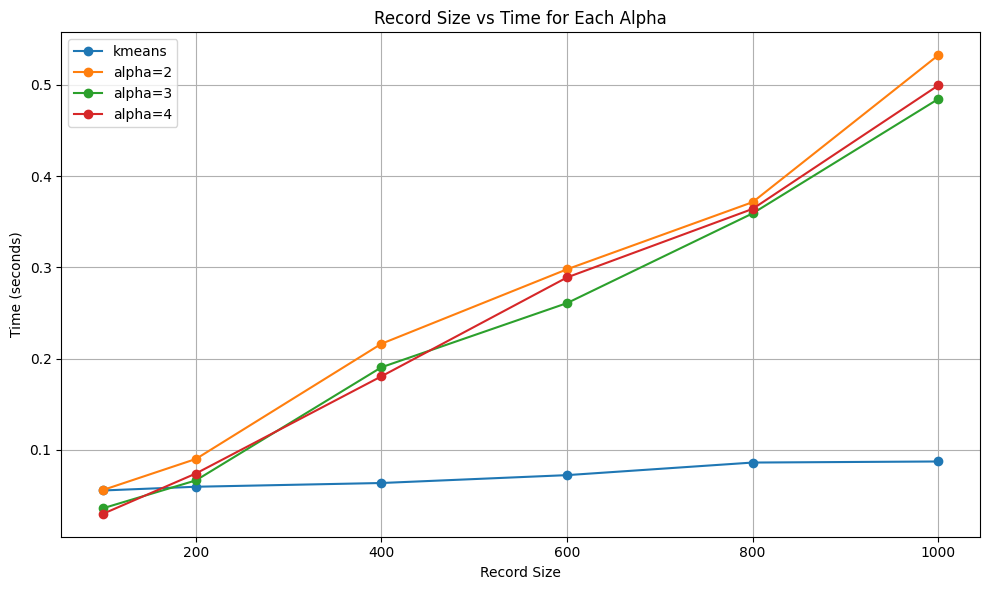

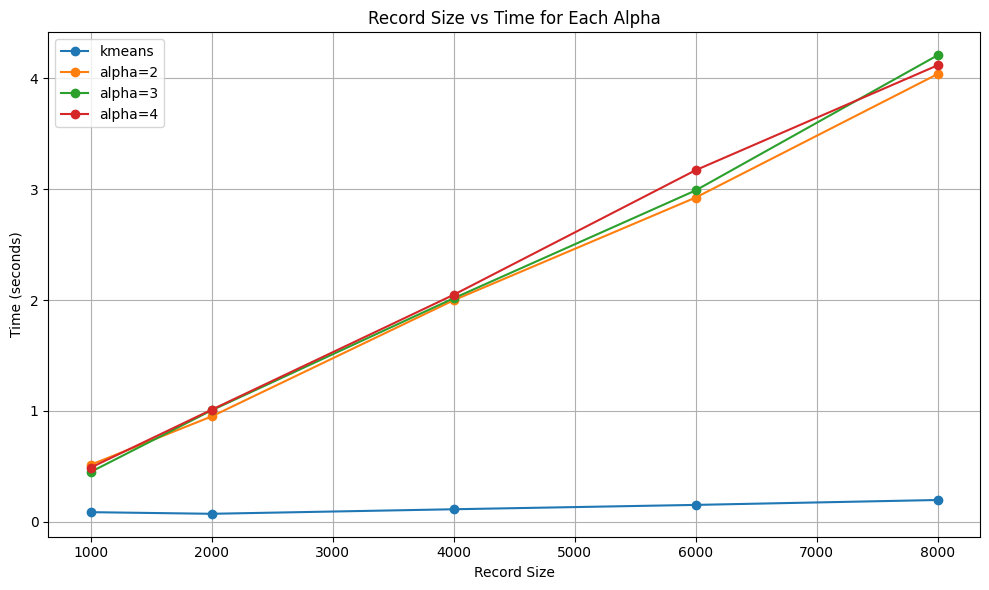

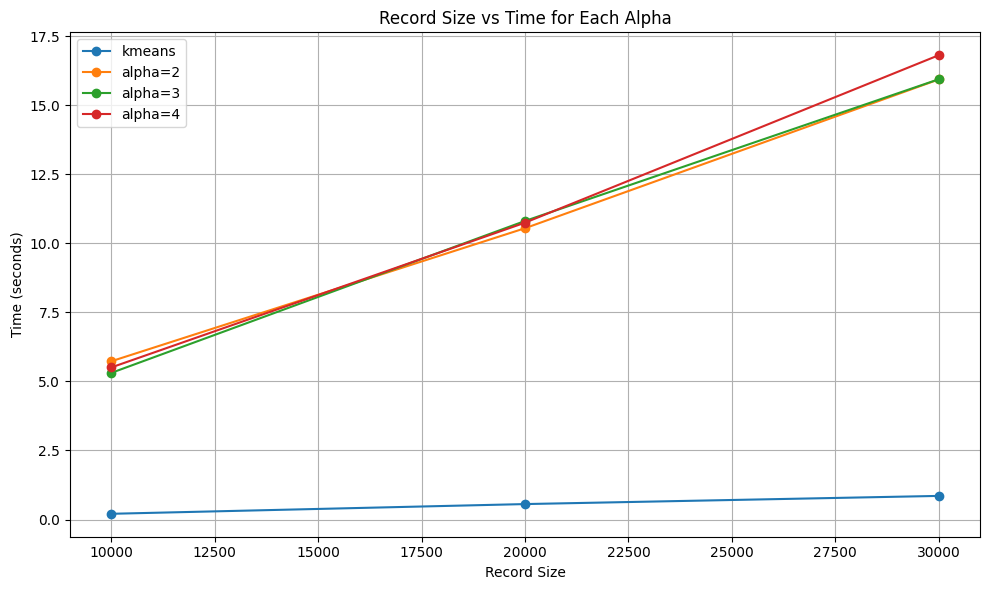

In [167]:
record_sizes = [
    [100, 200, 400, 600, 800, 1000],
    [1000, 2000, 4000, 6000, 8000],
    [10000, 20000, 30000]
]

for sizes in record_sizes:
    lhs_rc_vs_kmeans_eval(sizes)